#Price Prediction with LSTM

แม้ว่าแมชชีนเลิร์นนิงจะประสบความสำเร็จในการทำนายราคาตลาดหุ้น ผ่านแบบจำลองอนุกรมเวลาที่หลากหลาย แต่การประยุกต์ใช้ในการทำนายราคาสกุลเงินดิจิทัลนั้นค่อนข้างจำกัด

เหตุผลเนื่องจากราคาของ cryptocurrencies ขึ้นอยู่กับปัจจัยหลายอย่าง เช่น ความก้าวหน้าทางเทคโนโลยี การแข่งขันภายใน แรงกดดันในตลาด ปัญหาทางเศรษฐกิจ ปัญหาด้านความปลอดภัย ปัจจัยทางการเมือง แรงกระตุ้นของอินฟลูเอนเซอร์ เป็นต้น

แต่ความผันผวนที่สูง นำไปสู่การทำกำไรที่สูงด้วย ถ้าหากมีกลยุทธ์ที่ชาญฉลาด  น่าเสียดาย เนื่องจากไม่มีดัชนีสกุลเงินดิจิทัลจึงค่อนข้างคาดเดาไม่ได้เมื่อเทียบกับการคาดการณ์ทางการเงินแบบเดิม เช่น การทำนายตลาดหุ้น


เราจะมาทำการทำนายราคา โดยมี 4 ขั้นต้น


1. หาข้อมูลราคาแบบปัจจุบัน
2. จัดเตรียมข้อมูลสำหรับการเทรนนิ่งและการทดสอบ
3. ทำนายราคาของ cryptocurrency โดยใช้โครงข่ายประสาทเทียม LSTM
4. แสดงผลการทำนายด้วยกราฟ


ความท้าทาย
เพื่อคาดการณ์ราคาสกุลเงินดิจิทัลโดยใช้คุณสมบัติการซื้อขายทั้งหมด เช่น ราคา ปริมาณ ราคาเปิด ราคาสูงสุด ราคาต่ำค่าต่ำที่มีอยู่ในชุดข้อมูล


ข้อมูล
โหลดมาจากเว็บไซต์ CryptoCompare 
ชุดข้อมูลประกอบด้วยคุณสมบัติทั้งหมด 5 รายการ รายละเอียดสำหรับพวกเขามีดังนี้:
1. ราคาปิด — เป็นราคาปิดตลาดสำหรับสกุลเงินในวันนั้น ๆ
2. ราคาสูงสุด — เป็นราคาสูงสุดของสกุลเงินในวันนั้น
3. ราคาต่ำสุด — เป็นราคาต่ำสุดสำหรับสกุลเงินในวันนั้น
4. ราคาเปิด — เป็นราคาเปิดตลาดสำหรับสกุลเงินในวันนั้น
5. ปริมาณ — ปริมาณของสกุลเงินที่มีการซื้อขายในวันนั้น


เราจากการ import libraby ที่จำเป็น

In [62]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

เราจะใช้อัตราแลกเปลี่ยนเป็น USD และนำข้อมูลปัจจุบนมาใส่ใน pandas data-framw

ใช้เมธอด to_datetime() เพื่อแปลงข้อความ Date time ให้เป็นวัตถุ Python Date time สิ่งนี้จำเป็นเนื่องจากอ็อบเจ็กต์ Date time ในไฟล์ถูกอ่านเป็นอ็อบเจ็กต์สตริง
การดำเนินการเช่น ความแตกต่างของเวลาในสตริงแทนที่จะเป็นออบเจ็กต์ Date Time นั้นง่ายมาก เพราะการจัดการแบบสตริงจะง่ายกว่า

In [ ]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=1000')
# hist = pd.DataFrame(json.loads(res.content)['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# target_col = 'close'

In [66]:
jepx = pd.read_csv("df_jepx_spotsum.csv", parse_dates=['DATETIME','SYSTEM_PRICE'], usecols=[0,7])
# jepx = jepx.set_index('DATETIME')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19584\977208236.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jepx = pd.read_csv("df_jepx_spotsum.csv", parse_dates=['DATETIME','SYSTEM_PRICE'], usecols=[0,7])


In [67]:
jepx = pd.read_csv("df_jepx_spotsum.csv", parse_dates=['DATETIME'], usecols=[0,7])
# jepx = jepx.set_index('DATETIME')
target_col = 'SYSTEM_PRICE'

In [68]:
jepx

,DATETIME,SYSTEM_PRICE
0,2005-04-02 00:00:00,6.71
1,2005-04-02 00:30:00,6.65
2,2005-04-02 01:00:00,6.39
3,2005-04-02 01:30:00,6.39
4,2005-04-02 02:00:00,5.68
...,...,...
325819,2023-11-01 21:30:00,13.91
325820,2023-11-01 22:00:00,13.14
325821,2023-11-01 22:30:00,12.75
325822,2023-11-01 23:00:00,12.60


In [69]:
jepx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325824 entries, 0 to 325823
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DATETIME      325824 non-null  datetime64[ns]
 1   SYSTEM_PRICE  325824 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 MB


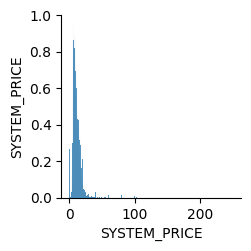

In [70]:
sns.pairplot(jepx)

In [71]:
jepx.head(5)

,DATETIME,SYSTEM_PRICE
0,2005-04-02 00:00:00,6.71
1,2005-04-02 00:30:00,6.65
2,2005-04-02 01:00:00,6.39
3,2005-04-02 01:30:00,6.39
4,2005-04-02 02:00:00,5.68


In [72]:
jepx.describe()

,DATETIME,SYSTEM_PRICE
count,325824,325824.000000
mean,2014-07-17 23:45:00.000001280,11.286967
min,2005-04-02 00:00:00,0.010000
25%,2009-11-23 23:52:30,7.120000
50%,2014-07-17 23:45:00,9.680000
75%,2019-03-10 23:37:30,13.790000
max,2023-11-01 23:30:00,251.000000
std,NaN,7.911367


In [ ]:
# jepx.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
# jepx = jepx[['DATE','TIME','SYSTEM_PRICE','HOKKAIDO','TOHOKU','TOKYO','CHUBU','HOKURIKU','KANSAI','CHUGOKU','SHIKOKU','KYUSHU']]

In [ ]:
# jepx = jepx[['DATETIME','SYSTEM_PRICE','BUY_VOLUME']]

In [74]:
jepx = jepx.dropna()
# jepx.fillna()

In [79]:
target_sysprice = 'SYSTEM_PRICE'

In [80]:
jepx

,DATETIME,SYSTEM_PRICE
0,2005-04-02 00:00:00,6.71
1,2005-04-02 00:30:00,6.65
2,2005-04-02 01:00:00,6.39
3,2005-04-02 01:30:00,6.39
4,2005-04-02 02:00:00,5.68
...,...,...
325819,2023-11-01 21:30:00,13.91
325820,2023-11-01 22:00:00,13.14
325821,2023-11-01 22:30:00,12.75
325822,2023-11-01 23:00:00,12.60


In [ ]:
# sns.lmplot(x='BUY_VOLUME', y=target_sysprice, data=jepx, ci=None,scatter_kws={'alpha': 0.4},line_kws={'color':'orange'})

In [ ]:
# jepx.drop(["DATE", "TIME"], axis = 'columns', inplace = True)

In [78]:
jepx.drop(["DATE"], axis = 'columns', inplace = True)

KeyError: "['DATE'] not found in axis"

In [ ]:
hist = jepx

In [ ]:
# hist.info()

In [ ]:
# hist.describe()

ถัดไปจะแบ่ง ข้อมูลเป็น 2 ส่วน 
training set 80% กับ test set 20%
แต่โดยทั่วไป การแบ่งข้อมูลมักแบ่งเป็นสามส่วน คือ  training, validation, testing (ส่วนสัด 60%, 20%, 20% ตามลำดับ).


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
# train, test = train_test_split(hist, test_size=0.2)

In [ ]:
train_jepx, test_jepx = train_test_split(jepx, test_size=0.2)

In [ ]:
test_jepx

พร็อตกราฟราคาในหน่วย USD 

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=1):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
#@title
# line_plot(train[target_col], test[target_col], 'training', 'test', title='')

ทำการ normalize ค่า เพื่อทำให้ค่าตัวเลขอยู่ในช่วงที่เหมาะสม ง่ายต่อการคำนวณ แต่ข้อมูลจะไม่ถูกบิดเบือน

In [ ]:
#@title
line_plot(train_jepx['SYSTEM_PRICE'], test_jepx['SYSTEM_PRICE'], 'training', 'test', title='')

In [ ]:
jepx.describe()

In [ ]:
def normalise_zero_base(df):
    return df 

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_sysprice, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_sysprice][window_len:].values
    y_test = test_data[target_sysprice][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_sysprice][:-window_len].values - 1
        y_test = y_test / test_data[target_sysprice][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

#LSTM
ทำงานโดยใช้เกตพิเศษเพื่อให้แต่ละเลเยอร์ LSTM รับข้อมูลจากทั้งเลเยอร์ก่อนหน้าและเลเยอร์ปัจจุบัน 
ข้อมูลต้องผ่านหลายเกต (เช่น forget gate, input gate ฯลฯ) และฟังก์ชัน activation ต่างๆ (เช่น ฟังก์ชัน tanh ฟังก์ชัน relu)

ข้อได้เปรียบหลักของสิ่งนี้คือช่วยให้เซลล์ LSTM แต่ละเซลล์จำรูปแบบได้เป็นระยะเวลาหนึ่ง

สิ่งที่ควรสังเกตคือ LSTM สามารถจดจำข้อมูลสำคัญและในขณะเดียวกันก็ลืมข้อมูลที่ไม่เกี่ยวข้อง




ตอนนี้เรามาสร้างโมเดลกัน 
โมเดลตาใช้เลเยอร์ทั้งหมด (อินพุต hidden และเอาต์พุต) โครงข่ายประสาทเทียมประกอบด้วยเลเยอร์ LSTM 
ตามด้วยเลเยอร์ Dense พร้อมฟังก์ชัน activation แบบ linear 

คอมไฟล์ ด้วย loss แบบ Mean Squared Error
และ optimizer แบบ adam


In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

กำหนดค่าพารามิเตอร์ที่จะต้องใช้ 

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 5
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

แบ่ง ข้อมูลเป็น X_train, X_test, y_train, y_test

In [ ]:
# train, test, X_train, X_test, y_train, y_test = prepare_data(
#     hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    jepx, target_sysprice, window_len=window_len, zero_base=zero_base, test_size=test_size)

สร้างโมเดล

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
jepx.info()

In [ ]:
targets = test[target_sysprice][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2